In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Suppress all warnings
warnings.filterwarnings("ignore")

### TitanicNewApproach

* 최고 기록 0.80143 (RandomForestClassifier 사용)
* 목표 점수 0.85~0.90 
* 점수 1.0은 의미가 없기 때문에 도달 목표로 삼지 않는다 

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 알아두면 좋은 정보
* Survived: 생존했는지 여부 (0 = 사망, 1 = 생존)
* PClass: 티켓 등급(1등급부터 3등급까지) / 사회경제적 지표 반영
* Sex: 성별(남녀)
* Age: 나이(예측치인 경우 소수점으로 표기함)
* sibsp: 타이타닉 내에 친척/배우자가 얼마만큼 탑승해 있었나
* parch: 타이타닉 내에 부모/자식이 얼마만큼 탑승해 있었나 (예: 조부모와 함께 탄 청소년의 경우는 0)
* Ticket: 티켓 번호 
* Fare: 지불한 요금 
* Cabin: 숙박실 이름
* Embark: 탑승 항구 이름 (C=셸부르, Q=퀸스타운, S=사우스햄프턴)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# 결측치의 비율을 plot으로 시각화하여 출력 
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count()*100).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    df = df[df["Percent"] > 0]
    f, ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='horizontal')
    fig=sns.barplot(df["Percent"], color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return df

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


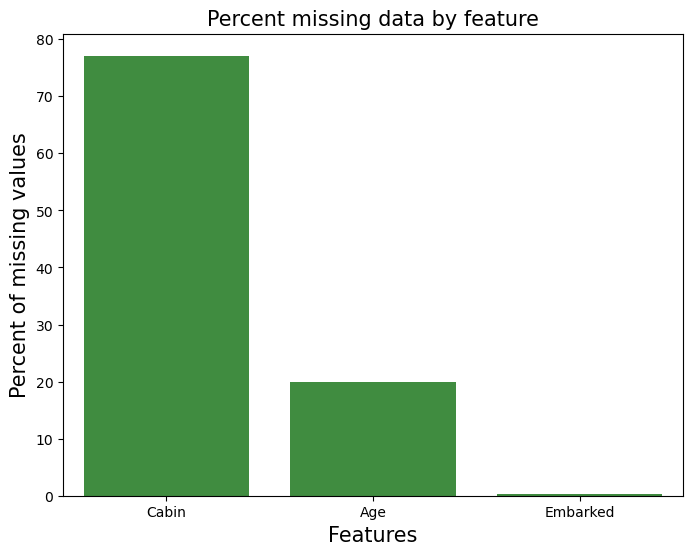

In [7]:
missingdata(train)

In [8]:
# 결측치 보완 (train)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
train['Age'].fillna(train['Age'].median(), inplace = True)

In [9]:
# 결측치 보완 (test)
test['Fare'].fillna(test['Fare'].median(), inplace = True)
test['Age'].fillna(test['Age'].median(), inplace = True)

In [10]:
drop_column = ['Cabin']
train.drop(drop_column, axis=1, inplace = True)
test.drop(drop_column, axis=1,inplace = True)

In [11]:
print('check NAN in the train data')
print(train.isnull().sum())
print('___'*21)
print('check NAN in the test data')
print(test.isnull().sum())

check NAN in the train data
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
_______________________________________________________________
check NAN in the test data
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [12]:
fullData = [train,test]

In [13]:
for dataset in fullData:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [14]:
import re
# 사람들의 이름을 정리합니다 (Mr, Mrs, Miss, Master, Rare의 다섯 개로 분류)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in fullData:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in fullData:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [15]:
for dataset in fullData:
        dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

In [16]:
for dataset in fullData:
        dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

In [17]:
df_tr = train
df_te = test
allData = [df_tr, df_te]

# 왜 새로 만들었나요?
# 이유: 레퍼런스를 만들어 앞으로의 작업을 원활히 하기 위해서입니다. 

In [18]:
for dataset in allData:
    drop_column = ['Age','Fare','Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

In [19]:
drop_column = ['PassengerId']
df_tr.drop(drop_column, axis=1, inplace = True)

In [20]:
df_te.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,Title,Fare_bin,Age_bin
0,892,3,male,0,0,Q,1,Mr,Low_fare,Adult
1,893,3,female,1,0,S,2,Mrs,Low_fare,Elder
2,894,2,male,0,0,Q,1,Mr,median_fare,Elder
3,895,3,male,0,0,S,1,Mr,median_fare,Adult
4,896,3,female,1,1,S,3,Mrs,median_fare,Adult


In [21]:
train = pd.get_dummies(train, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [22]:
test = pd.get_dummies(test, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [23]:
test.head()

,PassengerId,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,...,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,892,3,0,0,1,0,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
1,893,3,1,0,2,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2,894,2,0,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0
3,895,3,0,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
4,896,3,1,1,3,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


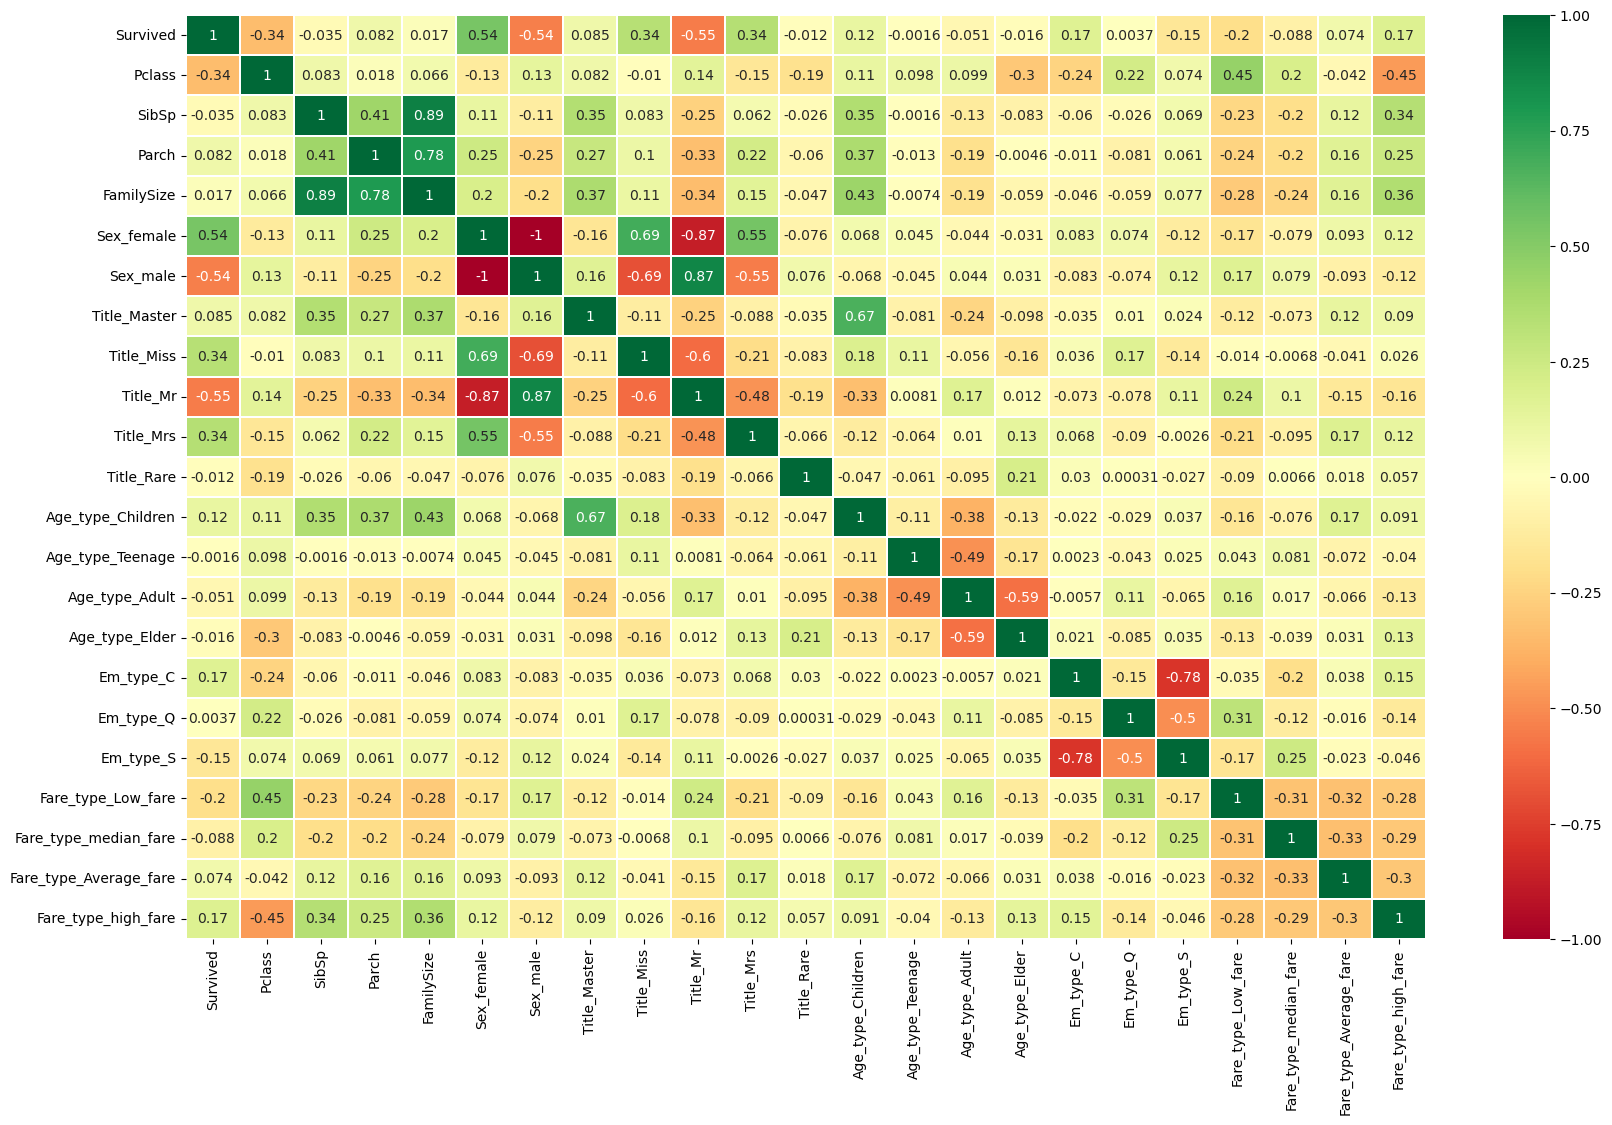

In [24]:
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20,12)
plt.show()

### 잠깐 멈추시오!

* 매우 연관된(또는 완벽하게 연관된) 두 지표가 있을 때, 두 지표는 서로 매우 비슷한 정보를 담고 있을 가능성이 매우 높습니다. 이 경우 두 지표는 내용의 정보 면에서 차이가 **없습니다**. 모델을 만들거나 훈련시킬 때 이러한 유형의 정보들은 훈련 시간을 증가시키고 효율성을 해칩니다.

* 위의 히트맵을 통해 알아본 바, 그 정도로 깊이 연관된 정보들이 보이지 않습니다. 계속 진행합니다. 

In [25]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import confusion_matrix 

In [26]:
all_features = train.drop("Survived", axis=1)
Targeted_feature = train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(all_features, Targeted_feature, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 22), (268, 22), (623,), (268,))

### Machine Learning

모델 정확도 측정 중:
로지스틱 회귀 모델의 정확도는:  82.46
로지스틱 회귀 모델의 교차 검증 점수는:  81.93


Text(0.5, 1.05, 'Confusion Matrix')

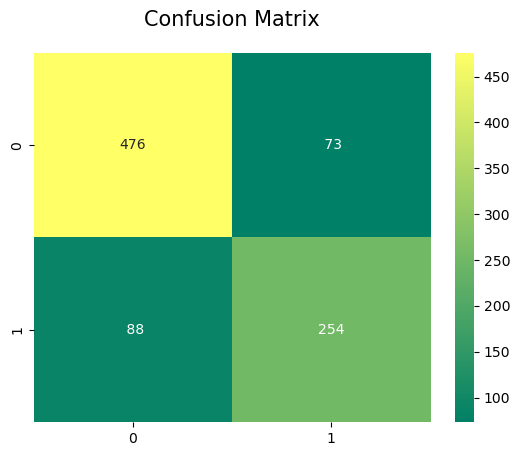

In [27]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression()
model.fit(X_train, y_train)
prediction_lr = model.predict(X_test)

print('모델 정확도 측정 중:')

print('로지스틱 회귀 모델의 정확도는: ', round(accuracy_score(prediction_lr, y_test)*100,2))
kfold = KFold(n_splits=10) 
result_lr = cross_val_score(model, all_features, Targeted_feature, cv=10, scoring='accuracy')

print('로지스틱 회귀 모델의 교차 검증 점수는: ',round(result_lr.mean()*100, 2))
y_pred = cross_val_predict(model, all_features, Targeted_feature, cv=10)
sns.heatmap(confusion_matrix(Targeted_feature, y_pred), annot=True, fmt='3.0f', cmap="summer")

plt.title('Confusion Matrix', y=1.05, size=15)

모델 정확도 측정 중:
랜덤 포레스트 모델의 정확도는:  82.46
랜덤 포레스트 모델의 교차 검증 점수는:  83.73


Text(0.5, 1.05, 'Confusion Matrix')

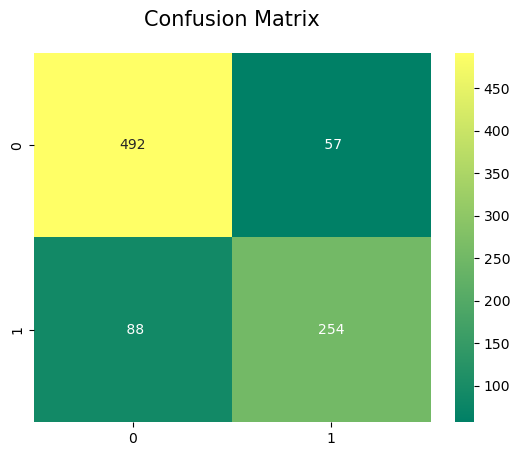

In [28]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10, min_samples_leaf=1,
                             max_features='auto', oob_score=True,
                             random_state=1, n_jobs=-1)

"""
* criterion = 'gini' | 지니 불순도 기준 'gini', 내부 정보량 기준 'entropy' 옵션 존재
* n_estimators = 700 | 내부의 트리 개수를 결정하는 옵션 (디폴트값은 100)
* min_samples_split = 10 | 내부 노드를 분할하는 데 사용할 최소 개수 (2에서 6 사이 추천, 디폴트값 2)
* min_samples_leaf = 1 | 분할 후에 노드 내에 담겨 있어야 할 최소 개수 (디폴트값 1, 너무 크면 과소적합 우려)
* max_features = 'auto' | 가장 적절한 결과를 도출하기 위해 우선시할 기능 (auto, sqrt, log2 또는 none 중에 선택)
* oob_score = True | Out-of-Bags 샘플을 사용할지 말지의 여부 
* random_state = 1 | 알고리즘의 랜덤 형질을 결정, int값을 받으면 랜덤으로 생성된 임의의 시드를 적용 
* n_jobs = -1 | 사용할 코어 개수, -1은 코어 전부 할당
"""

model.fit(X_train, y_train)
prediction_rm = model.predict(X_test)

print('모델 정확도 측정 중:')

print('랜덤 포레스트 모델의 정확도는: ', round(accuracy_score(prediction_rm, y_test)*100, 2))
kfold = KFold(n_splits=10) 
result_rm = cross_val_score(model, all_features, Targeted_feature, cv=10, scoring='accuracy')

print('랜덤 포레스트 모델의 교차 검증 점수는: ', round(result_rm.mean()*100, 2))
y_pred = cross_val_predict(model, all_features, Targeted_feature, cv=10)
sns.heatmap(confusion_matrix(Targeted_feature, y_pred), annot=True, fmt='3.0f', cmap="summer")

plt.title('Confusion Matrix', y=1.05, size=15)

모델 정확도 측정 중:
SVM 모델의 정확도는:  83.58
SVM 모델의 교차 검증 점수는:  83.16


Text(0.5, 1.05, 'Confusion Matrix')

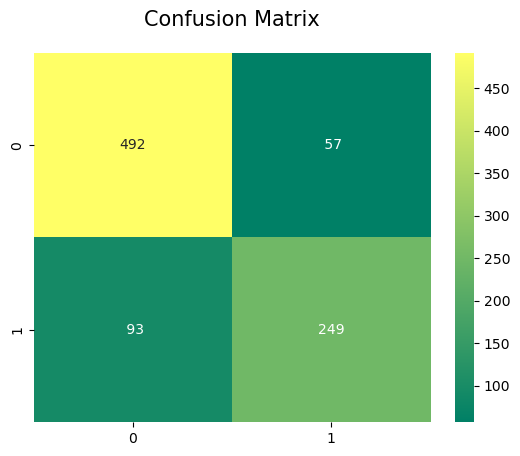

In [29]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train,y_train)
prediction_svm = model.predict(X_test)

print('모델 정확도 측정 중:')

print('SVM 모델의 정확도는: ', round(accuracy_score(prediction_svm, y_test)*100, 2))
kfold = KFold(n_splits=10) 
result_svm = cross_val_score(model, all_features, Targeted_feature, cv=10, scoring='accuracy')

print('SVM 모델의 교차 검증 점수는: ', round(result_svm.mean()*100, 2))
y_pred = cross_val_predict(model, all_features, Targeted_feature, cv=10)
sns.heatmap(confusion_matrix(Targeted_feature, y_pred), annot=True, fmt='3.0f', cmap="summer")

plt.title('Confusion Matrix', y=1.05, size=15)

모델 정확도 측정 중:
KNN 모델의 정확도는:  79.48
KNN 모델의 교차 검증 점수는:  80.02


Text(0.5, 1.05, 'Confusion Matrix')

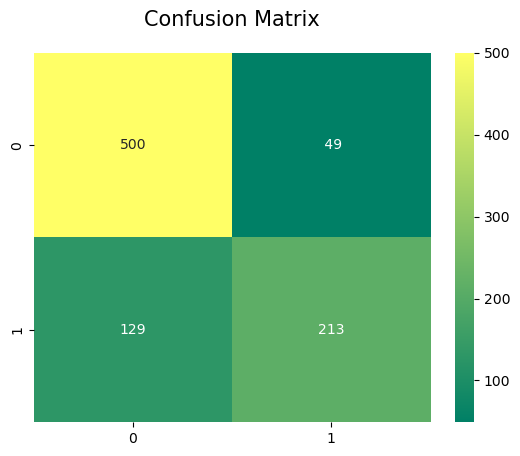

In [30]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 4)
model.fit(X_train, y_train)
prediction_knn = model.predict(X_test)

print('모델 정확도 측정 중:')
print('KNN 모델의 정확도는: ', round(accuracy_score(prediction_knn, y_test)*100, 2))
kfold = KFold(n_splits=10) 
result_knn = cross_val_score(model, all_features, Targeted_feature, cv=10, scoring='accuracy')

print('KNN 모델의 교차 검증 점수는: ', round(result_knn.mean()*100, 2))
y_pred = cross_val_predict(model, all_features, Targeted_feature, cv=10)
sns.heatmap(confusion_matrix(Targeted_feature, y_pred), annot=True, fmt='3.0f', cmap="summer")

plt.title('Confusion Matrix', y=1.05, size=15)

모델 정확도 측정 중:
연속형 나이브-베이즈 모델의 정확도는:  79.48
연속형 나이브-베이즈 모델의 교차 검증 점수는: 79.8


Text(0.5, 1.05, 'Confusion Matrix')

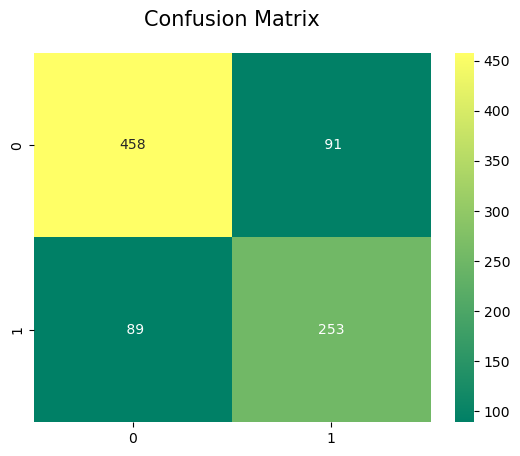

In [31]:
from sklearn.naive_bayes import GaussianNB

model= GaussianNB()
model.fit(X_train, y_train)
prediction_gnb=model.predict(X_test)

print('모델 정확도 측정 중:')

print('연속형 나이브-베이즈 모델의 정확도는: ', round(accuracy_score(prediction_gnb, y_test)*100,2))
kfold = KFold(n_splits=10) 
result_gnb = cross_val_score(model, all_features, Targeted_feature, cv=10, scoring='accuracy')

print('연속형 나이브-베이즈 모델의 교차 검증 점수는:', round(result_gnb.mean()*100, 2))
y_pred = cross_val_predict(model, all_features, Targeted_feature, cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred), annot=True, fmt='3.0f', cmap="summer")

plt.title('Confusion Matrix', y=1.05, size=15)

모델 정확도 측정 중:
의사결정 나무 모델의 정확도는:  78.36
의사결정 나무 모델의 교차 검증 점수는:  80.7


Text(0.5, 1.05, 'Confusion Matrix')

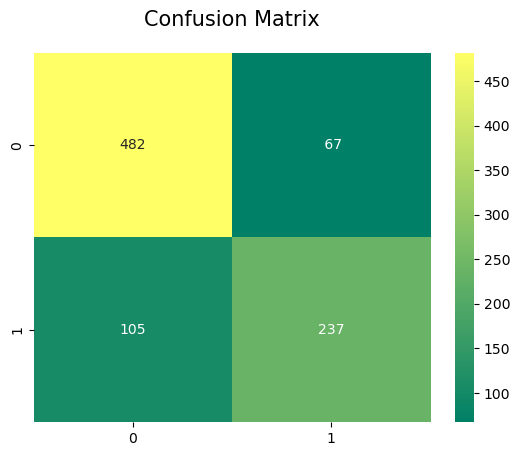

In [32]:
from sklearn.tree import DecisionTreeClassifier

model= DecisionTreeClassifier(criterion = 'gini', 
                             min_samples_split = 10,min_samples_leaf = 1,
                             max_features = 'auto')
model.fit(X_train, y_train)
prediction_tree = model.predict(X_test)

print('모델 정확도 측정 중:')
print('의사결정 나무 모델의 정확도는: ', round(accuracy_score(prediction_tree,y_test)*100, 2))
kfold = KFold(n_splits=10)
result_tree = cross_val_score(model, all_features, Targeted_feature, cv=10, scoring='accuracy')

print('의사결정 나무 모델의 교차 검증 점수는: ', round(result_tree.mean()*100, 2))
y_pred = cross_val_predict(model, all_features, Targeted_feature, cv=10)
sns.heatmap(confusion_matrix(Targeted_feature, y_pred), annot=True, fmt='3.0f', cmap="summer")

plt.title('Confusion Matrix', y=1.05, size=15)

모델 정확도 측정 중:
에이다부스트 모델의 정확도는: 80.22
에이다부스트 모델의 교차 검증 점수는:  81.03


Text(0.5, 1.05, 'Confusion Matrix')

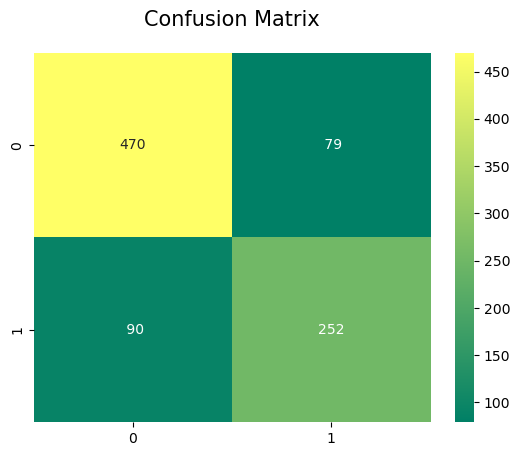

In [33]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train, y_train)
prediction_adb = model.predict(X_test)

print('모델 정확도 측정 중:')
print('에이다부스트 모델의 정확도는:', round(accuracy_score(prediction_adb, y_test)*100, 2))
kfold = KFold(n_splits=10)
result_adb = cross_val_score(model, all_features, Targeted_feature, cv=10, scoring='accuracy')

print('에이다부스트 모델의 교차 검증 점수는: ', round(result_adb.mean()*100, 2))
y_pred = cross_val_predict(model, all_features, Targeted_feature, cv=10)
sns.heatmap(confusion_matrix(Targeted_feature, y_pred), annot=True, fmt='3.0f', cmap="summer")

plt.title('Confusion Matrix', y=1.05, size=15)

모델 정확도 측정 중:
선형판별분석 모델의 정확도는:  82.84
선형판별분석 모델의 교차 검증 점수는:  82.38


Text(0.5, 1.05, 'Confusion Matrix')

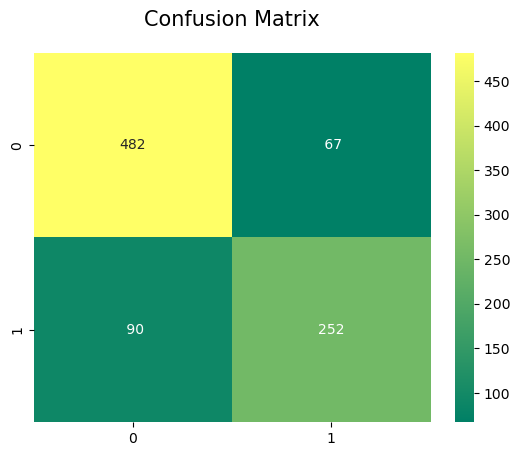

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis()
model.fit(X_train,y_train)
prediction_lda = model.predict(X_test)

print('모델 정확도 측정 중:')
print('선형판별분석 모델의 정확도는: ', round(accuracy_score(prediction_lda, y_test)*100, 2))
kfold = KFold(n_splits=10)
result_lda = cross_val_score(model, all_features, Targeted_feature, cv=10, scoring='accuracy')

print('선형판별분석 모델의 교차 검증 점수는: ', round(result_lda.mean()*100, 2))
y_pred = cross_val_predict(model, all_features, Targeted_feature, cv=10)
sns.heatmap(confusion_matrix(Targeted_feature, y_pred), annot=True, fmt='3.0f', cmap="summer")

plt.title('Confusion Matrix', y=1.05, size=15)

모델 정확도 측정 중:
그래디언트 부스팅 모델의 정확도는:  82.46
그래디언트 부스팅 모델의 교차 검증 점수는: 82.05


Text(0.5, 1.05, 'Confusion Matrix')

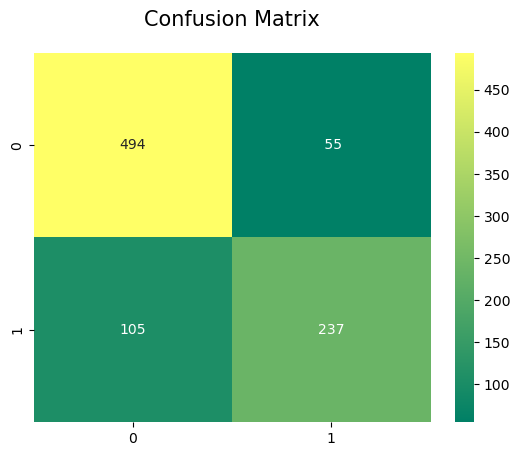

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train,y_train)
prediction_gbc = model.predict(X_test)

print('모델 정확도 측정 중:')
print('그래디언트 부스팅 모델의 정확도는: ', round(accuracy_score(prediction_gbc, y_test)*100, 2))
kfold = KFold(n_splits=10)
result_gbc = cross_val_score(model, all_features, Targeted_feature, cv=10, scoring='accuracy')

print('그래디언트 부스팅 모델의 교차 검증 점수는:', round(result_gbc.mean()*100, 2))
y_pred = cross_val_predict(model, all_features, Targeted_feature, cv=10)
sns.heatmap(confusion_matrix(Targeted_feature, y_pred), annot=True, fmt='3.0f', cmap="summer")

plt.title('Confusion Matrix', y=1.05, size=15)

In [36]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'AdaBoostClassifier', 
              'Gradient Decent', 'Linear Discriminant Analysis', 
              'Decision Tree'],
    'Score': [result_svm.mean(), result_knn.mean(), result_lr.mean(), 
              result_rm.mean(), result_gnb.mean(), result_adb.mean(), 
              result_gbc.mean(), result_lda.mean(), result_tree.mean()]})
models.sort_values(by='Score',ascending=False)

,Model,Score
3,Random Forest,0.837303
0,Support Vector Machines,0.831648
7,Linear Discriminant Analysis,0.823820
6,Gradient Decent,0.820474
2,Logistic Regression,0.819301
5,AdaBoostClassifier,0.810325
8,Decision Tree,0.807004
1,KNN,0.800225
4,Naive Bayes,0.798002


In [37]:
train_X = train.drop("Survived", axis=1)
train_Y = train["Survived"]
test_X = test.drop("PassengerId", axis=1).copy()
train_X.shape, train_Y.shape, test_X.shape

((891, 22), (891,), (418, 22))

### (또) 잠깐 멈추시오! 

* 각각의 모델에는 디폴트값으로 하이퍼패러미터가 지정되어 있습니다. 하지만 이 값들은 더 나은 모델을 위해 사용자가 지정하는 것이 가능합니다. 이것을 하이퍼패러미터 튜닝이라고 합니다. 이하는 예시입니다. 

In [38]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300,400],
              'learning_rate': [0.1, 0.05, 0.01,0.001],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.2,0.1] 
              }

modelgb = GridSearchCV(model, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
modelgb.fit(train_X, train_Y)

print(modelgb.best_score_)
print(modelgb.best_estimator_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
0.8215980024968788
GradientBoostingClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                           n_estimators=400)


In [39]:
model = RandomForestClassifier()
n_estim = range(100, 1000, 100)

param_grid = {"n_estimators":n_estim}

model_rf = GridSearchCV(model, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=4, verbose=1)
model_rf.fit(train_X, train_Y)

print(model_rf.best_score_)
print(model_rf.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.8238277572029377
RandomForestClassifier(n_estimators=900)


In [40]:
model = LinearDiscriminantAnalysis()
param_grid = {'tol':[0.001,0.01,.1,.2]}

model_ld = GridSearchCV(model, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=4, verbose=1)
model_ld.fit(train_X,train_Y)

print(model_ld.best_score_)
print(model_ld.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.8215491808423827
LinearDiscriminantAnalysis(tol=0.001)


In [41]:
model= SVC()
param_grid = {'kernel': ['rbf','linear'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

modelsv = GridSearchCV(model,param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)
modelsv.fit(train_X,train_Y)

print(modelsv.best_estimator_)
print(modelsv.best_score_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
SVC(C=50, gamma=0.01)
0.8338710689849979


In [42]:
""" param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(8, 13),
    'min_samples_split': range(6, 11),
    'min_samples_leaf': range(1, 4),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [0],
    'oob_score': [True, False],
    'verbose': [0, 1, 2, 3],
    'max_leaf_nodes': range(80, 101, 2),
    'class_weight': [{0: 1, 1: w} for w in np.linspace(1.3, 1.7, 5)],
    'ccp_alpha': np.linspace(4e-05, 6e-05, 5),
    'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4],
    'warm_start': [True, False]
}

dt_classifier = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters found:")
print(grid_search.best_params_) """

' param_grid = {\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'splitter\': [\'best\', \'random\'],\n    \'max_depth\': range(8, 13),\n    \'min_samples_split\': range(6, 11),\n    \'min_samples_leaf\': range(1, 4),\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\', None],\n    \'random_state\': [0],\n    \'oob_score\': [True, False],\n    \'verbose\': [0, 1, 2, 3],\n    \'max_leaf_nodes\': range(80, 101, 2),\n    \'class_weight\': [{0: 1, 1: w} for w in np.linspace(1.3, 1.7, 5)],\n    \'ccp_alpha\': np.linspace(4e-05, 6e-05, 5),\n    \'min_weight_fraction_leaf\': [0.1, 0.2, 0.3, 0.4],\n    \'min_impurity_decrease\': [0.0, 0.1, 0.2, 0.3, 0.4],\n    \'warm_start\': [True, False]\n}\n\ndt_classifier = DecisionTreeClassifier()\ngrid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring=\'accuracy\', verbose=1, n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\nprint("Best Parameters found:")\nprint(grid_search.best_params_) '

Important features
____________________________________________________________
86.64


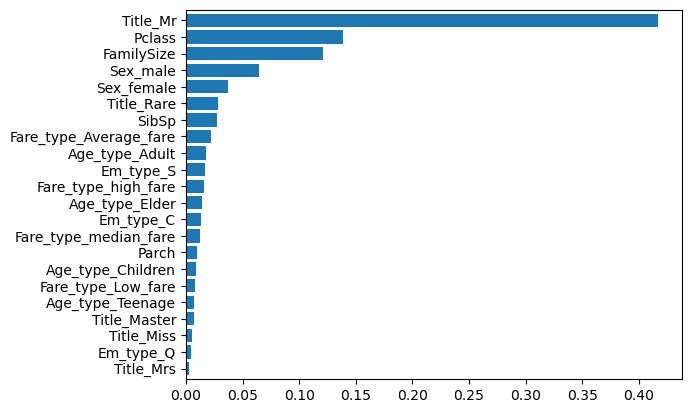

In [44]:
base_params = {
    'ccp_alpha': 4e-05,
    'class_weight': {0: 1, 1: 1.5},
    'criterion': 'gini',
    'max_depth': 9,
    'max_features': None,
    'max_leaf_nodes': 80,
    'min_samples_leaf': 3,
    'min_samples_split': 9,
    'random_state': 0,
}

random_forest = RandomForestClassifier(**base_params)
random_forest.fit(train_X, train_Y)

Y_pred_rf = random_forest.predict(test_X)
random_forest.score(train_X, train_Y)

acc_random_forest = round(random_forest.score(train_X, train_Y) * 100, 2)

print("Important features")
pd.Series(random_forest.feature_importances_, train_X.columns).sort_values(ascending=True).plot.barh(width=0.8)
print('__'*30)
print(acc_random_forest)

In [46]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred_rf})

submission.to_csv('new_submission.csv', index=False)